In [8]:
%set_env GOOGLE_APPLICATION_CREDENTIALS=C:\Users\Mark\Desktop\PurdueEats-e85c448de7a4.json

env: GOOGLE_APPLICATION_CREDENTIALS=C:\Users\Mark\Desktop\PurdueEats-e85c448de7a4.json


In [69]:
from google.cloud import bigquery
import sys
from backend.DB.Util import runQuery
from backend.API.routes.menu import get_nutrition, nutrition_to_macros, get_menu_item
import pandas as pd
import datetime

gcp_project = "purdueeats-304919"
bq_dataset = "PurdueEatsDatabase"

client = bigquery.Client(project=gcp_project)
dataset_ref = client.dataset(bq_dataset)

def userReviewsSummary(UserID):
    reviews = runQuery( f"select user.UserID, MenuItemID, Rating, Timestamp from UserBasic as user Inner Join MenuItemsReviews as txn on user.UserID = txn.UserID WHERE user.UserID = {UserID}")
    return reviews.to_dataframe()

def userTransactionsSummary(UserID):
    transactions = runQuery( f"select user.UserID, TransactionAmount, Balance, Timestamp from UserBasic as user Inner Join UserTransaction as txn on user.UserID = txn.UserID WHERE user.UserID = {UserID}")
    return transactions.to_dataframe()

def getMenuItemName(MenuItemID):
    rtn = runQuery( f"select ItemName from MenuItems WHERE MenuItemID = {MenuItemID}").to_dataframe()
    rtn.columns = [''] * len(rtn.columns)
    return rtn

df = userReviewsSummary(7023699889393535879) #use 7023699889393535879 for example
df['first_day_of_week'] = df["Timestamp"].apply(lambda df:
                                        datetime.datetime(year=df.year, month=df.month, day=df.day))
df.set_index(df["first_day_of_week"], inplace=True) #makes lines 56-59 run

calories = [] #these empty lists will be populated with in the for loop below, then added as columns to dataset.
carbs = []
fat = []
protein = []
menuItemStr = []

for i, row in df.iterrows():
    menu_item_id = row[1] #this is the menu item id
    menuItemStr.append(getMenuItemName(menu_item_id).loc[0].to_string()[4:])
    response = get_nutrition(menu_item_id)
    _calories, _carbs, _fat, _protein = nutrition_to_macros(response)
    calories.append(_calories)
    carbs.append(_carbs)
    fat.append(_fat)
    protein.append(_protein)
df['calories'] = calories
df['carbs'] = carbs
df['fat'] = fat
df['protein'] = protein
df['menuItemStr'] = menuItemStr

weekly_avg_calories = df.calories.resample('W').sum() / df.first_day_of_week.resample('W').count()
weekly_avg_carbs = df.carbs.resample('W').sum() / df.first_day_of_week.resample('W').count()
weekly_avg_fat = df.fat.resample('W').sum() / df.first_day_of_week.resample('W').count()
weekly_avg_protein = df.protein.resample('W').sum() / df.first_day_of_week.resample('W').count()
#sum of total calories per week / number of active input days per week

#counting unique occurences
df['menuItemStr'] = df['menuItemStr'].str.split()
menu_item_count = df['menuItemStr'].apply(pd.Series).stack().reset_index(drop=True).value_counts()
#menu_item_count = df['MenuItemID'].value_counts() #obsolete line that returns menu item id with count

# this is to calculate user transactions
df2 = userTransactionsSummary(7023699889393535879)
df2['first_day_of_week'] = df2["Timestamp"].apply(lambda df2:
                                        datetime.datetime(year=df2.year, month=df2.month, day=df2.day))
df2.set_index(df2["first_day_of_week"], inplace=True) #makes line 74 run
weekly_summary_trans = df2.TransactionAmount.resample('W').sum()

print("\nMenu Item Count is used for word cloud. It contains the menu item # followed by the count.")
print(f"\nmenu_item_count: \n{menu_item_count}") #frequency count of menu items; for word cloud

print("\nWeekly macro averages are below. They're in Series format and can thus be plotted. The index is the first day of the week, the values are average macro consumed of that week")
print(f"\nweekly_avg_calories: \n{weekly_avg_calories}") #this is a series
print(f"\nweekly_avg_carbs: \n{weekly_avg_carbs}")  # this is a series
print(f"\nweekly_avg_fat: \n{weekly_avg_fat}") #this is a series
print(f"\nweekly_avg_protein: \n{weekly_avg_protein}") #this is a series
print("\nWeekly sum transactions averages are below. They're in the same format as above.")
print(f"\nweekly_summary_trans \n{weekly_summary_trans}") #this is a series.


In [17]:
def mealPlanSummary():
    mealPlans = runQuery( f"SELECT MealPlan.MealPlanName FROM UserBasic INNER JOIN UserExtra ON UserBasic.UserID=UserExtra.UserID INNER JOIN MealPlan ON UserExtra.MealPlanName = MealPlan.MealPlanName")
    return mealPlans.to_dataframe()
    

In [22]:
mealPlansDF = mealPlanSummary()
mealPlansDF

,MealPlanName
0,15 Meal Plan +450
1,21 Meal Plan +250
2,21 Meal Plan +250
3,15 Meal Plan +450
4,10 Meal Plan +100
5,15 Meal Plan +450
6,15 Meal Plan +450
7,15 Meal Plan +450
8,21 Meal Plan +500
9,21 Meal Plan +500


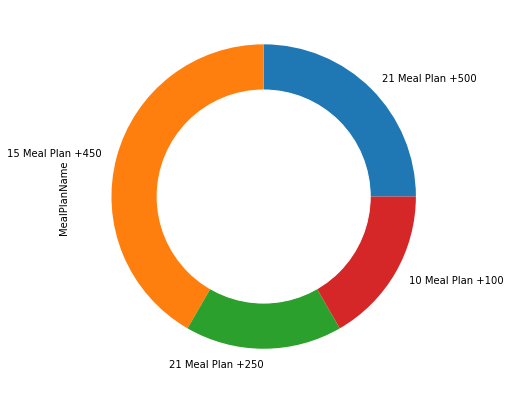

In [35]:
import matplotlib.pyplot as plt
mealPlansDF.MealPlanName.value_counts(sort=False).plot.pie(figsize = (7,7))
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [85]:
def getAllUsers():
    allUsers = runQuery(f"SELECT UserID FROM UserBasic")
    return allUsers.to_dataframe()
allUserID = getAllUsers()

In [98]:
#WARNING: RUNTIME IS A MILLION YEARS
masterList = []

for UserID in allUserID.UserID.tolist():
    print(UserID)
    df = userReviewsSummary(UserID) #use 7023699889393535879 for example
    df['first_day_of_week'] = df["Timestamp"].apply(lambda df:
                                            datetime.datetime(year=df.year, month=df.month, day=df.day))
    df.set_index(df["first_day_of_week"], inplace=True) #makes lines 56-59 run
    menuItemStr = []


    for i, row in df.iterrows():
        menu_item_id = row[1] #this is the menu item id
        menuItemStr.append(getMenuItemName(menu_item_id).loc[0].to_string()[4:])
    df['menuItemStr'] = menuItemStr

    #counting unique occurences
    if not menuItemStr: #if the list is empty:
        print("User has made no reviews!")
    else:
        df['menuItemStr'] = df['menuItemStr'].str.split()
        masterList.append(df['menuItemStr'].apply(pd.Series).stack().reset_index(drop=True))
masterList

4087605085059207658
8868460133119895895
User has made no reviews!
-2589269694930711347
1589774858082006536


6967645914836607210
8788104928683024331
4467606805034911759
7023699889393535879
-6972977857218552086
-2950671479005323586
0
-7051850150604121449


3183534950451599476
User has made no reviews!
-5179890033796933917
User has made no reviews!
188163777591238077
User has made no reviews!
-8325608802771069211


[0      Cavatini
 1         Whole
 2         Green
 3         Beans
 4         Ancho
          ...   
 207      Thighs
 208     Coconut
 209        Rice
 210      Smokey
 211       Links
 Length: 212, dtype: object,
 0        Raisins
 1        Vanilla
 2      Sunflower
 3         Butter
 4         Cashew
          ...    
 105         Stir
 106          Fry
 107     Sundried
 108       Tomato
 109      Risotto
 Length: 110, dtype: object,
 0           Sliced
 1     Strawberries
 2          Raisins
 3             Hard
 4           Cooked
 5             Eggs
 6             Rice
 7             Chex
 8           Cereal
 9         Parmesan
 10         Roasted
 11      Fingerling
 12        Potatoes
 13       Meatballs
 14            with
 15        Marinara
 16          Gluten
 17            Free
 18          Peanut
 19          Butter
 20          Cookie
 21         Roasted
 22       Chickpeas
 23           Fried
 24         Chicken
 25          Gluten
 26            Free
 27            So

In [136]:
flatList = [ item for elem in masterList for item in elem] #turn list of lists into single list
d = {x:flatList.count(x) for x in flatList}

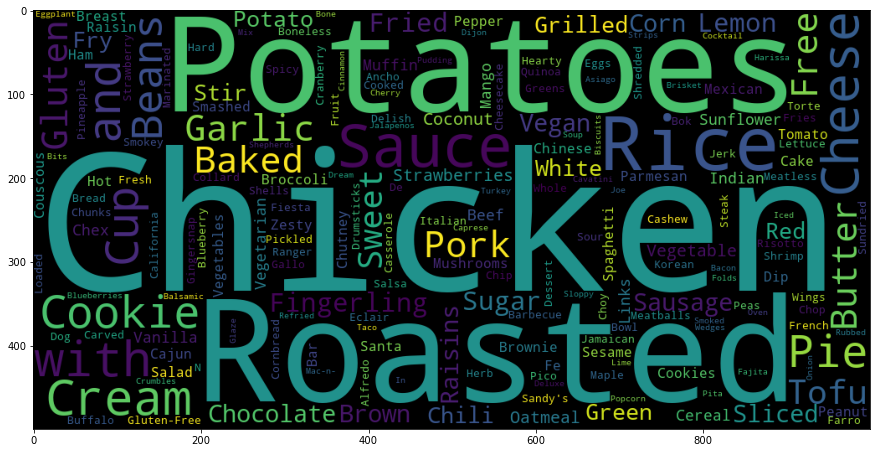

In [135]:
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#wc = WordCloud(background_color="white",width=3000,height=3000, max_words=30,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(d)
#plt.imshow(wc)


wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)